In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# LNG-focused equities
lng_stocks = {
    "Shell": "SHEL",
}

# Renewable-focused equities
renewable_stocks = {
    "Brookfield Renewable": "BEP",
    "Boralex": "BLX.TO",
    "NextEra Energy": "NEE"
}

tickers = {**lng_stocks, **renewable_stocks}

In [3]:
# Download data from 2006 to present
raw = yf.download(
    tickers=list(tickers.values()),
    start="2006-01-01",
    auto_adjust=True,
    progress=False
)

data = raw["Close"] if isinstance(raw.columns, pd.MultiIndex) else raw

# Download natural gas prices
gas = yf.download(
    "NG=F",
    start="2006-01-01",
    auto_adjust=True,
    progress=False
)["Close"]

# Define train and test periods
train_start = "2006-01-01"
train_end = "2015-01-01"
test_start = "2015-01-01"
test_end = "2025-01-01"

In [4]:
coverage = []

for name, ticker in tickers.items():
    if ticker not in data.columns:
        coverage.append({
            "Name": name,
            "Ticker": ticker,
            "First Date": None,
            "Last Date": None,
            "Total Obs": 0,
            "NA Count": None
        })
        continue
    
    series = data[ticker]
    non_na = series.dropna()
    
    coverage.append({
        "Name": name,
        "Ticker": ticker,
        "First Date": non_na.index.min(),
        "Last Date": non_na.index.max(),
        "Total Obs": non_na.shape[0],
        "NA Count": series.isna().sum()
    })

coverage_df = pd.DataFrame(coverage).sort_values("First Date")

print("\nDATA COVERAGE SUMMARY")
print("=" * 60)
print(coverage_df)


DATA COVERAGE SUMMARY
                   Name  Ticker First Date  Last Date  Total Obs  NA Count
0                 Shell    SHEL 2006-01-03 2025-12-31       5031        93
1  Brookfield Renewable     BEP 2006-01-03 2025-12-31       5031        93
2               Boralex  BLX.TO 2006-01-03 2025-12-31       5020       104
3        NextEra Energy     NEE 2006-01-03 2025-12-31       5031        93


In [5]:
# Change these variables to switch between train/test periods
period_name = "TRAIN (2006-2015)"
start = train_start
end = train_end

print(f"\n{'='*60}")
print(f"ANALYZING {period_name} PERIOD: {start} to {end}")
print(f"{'='*60}\n")

# Filter data to period
data_mask = (data.index >= start) & (data.index < end)
gas_mask = (gas.index >= start) & (gas.index < end)

period_data = data[data_mask].copy()
period_gas = gas[gas_mask].copy()

# Align gas data to equity data index
period_gas = period_gas.reindex(period_data.index).ffill()


ANALYZING TRAIN (2006-2015) PERIOD: 2006-01-01 to 2015-01-01



Ticker
BEP        4.333741
BLX.TO     5.964472
NEE        5.810507
SHEL      23.555483
Name: 2006-01-03 00:00:00, dtype: float64


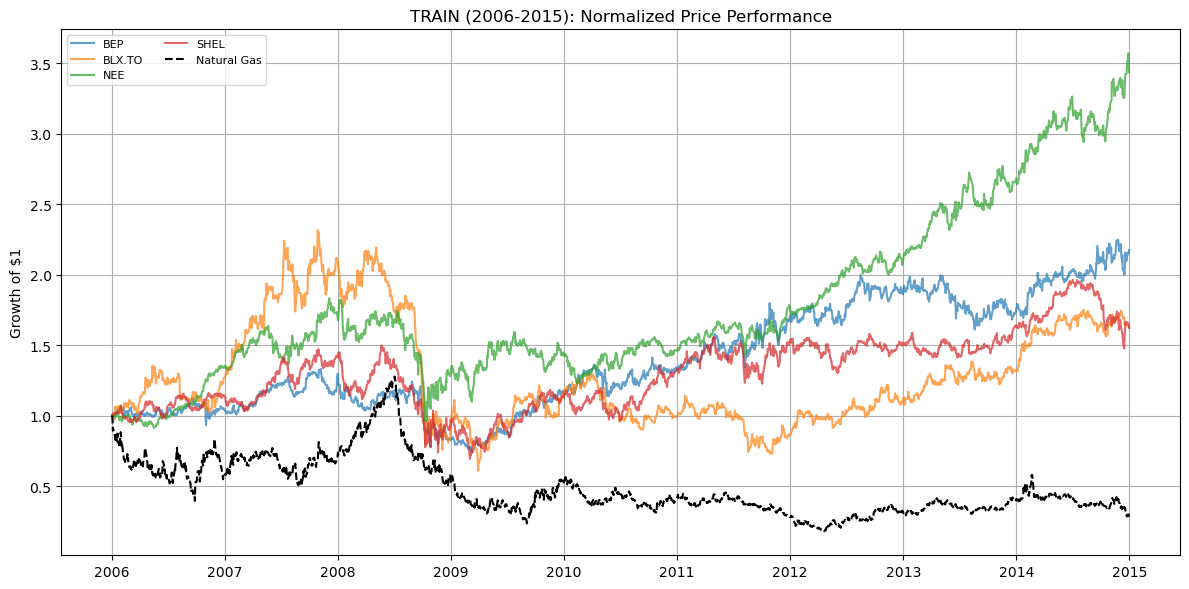

In [6]:
# Align all stocks by dropping any row with missing data
aligned_data = period_data.dropna(axis=0, how='any')

# Normalize by first row after alignment
normalized = aligned_data / aligned_data.iloc[0]

# Normalize gas the same way (align by index)
gas_norm = period_gas.reindex(aligned_data.index) / period_gas.reindex(aligned_data.index).iloc[0]

print(aligned_data.iloc[0])  # Shows first row used for normalization

# Plot
plt.figure(figsize=(12,6))
for col in normalized.columns:
    plt.plot(normalized.index, normalized[col], label=col, alpha=0.7)

plt.plot(gas_norm.index, gas_norm, color='black', linestyle='--', label='Natural Gas')

plt.title(f"{period_name}: Normalized Price Performance")
plt.ylabel("Growth of $1")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


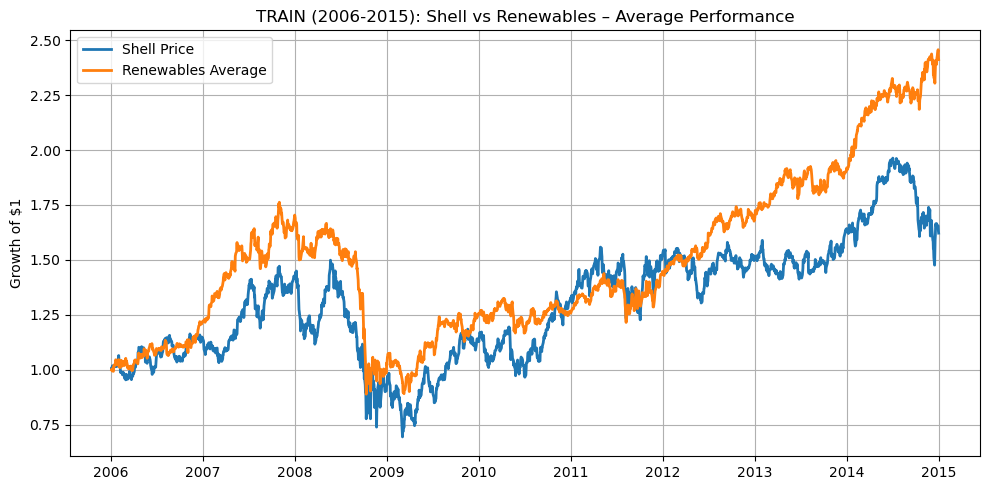

In [7]:
lng_prices = normalized[[t for t in lng_stocks.values() if t in normalized.columns]]
renew_prices = normalized[[t for t in renewable_stocks.values() if t in normalized.columns]]

lng_avg = lng_prices.mean(axis=1)
renew_avg = renew_prices.mean(axis=1)

plt.figure(figsize=(10,5))
plt.plot(lng_avg, label="Shell Price", linewidth=2)
plt.plot(renew_avg, label="Renewables Average", linewidth=2)

plt.title(f"{period_name}: Shell vs Renewables – Average Performance")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
returns = period_data.pct_change().dropna()

summary = pd.DataFrame({
    "Annual Return": returns.mean() * 252,
    "Annual Volatility": returns.std() * (252 ** 0.5)
})

print(f"\n{period_name} Risk-Return Summary:")
print(summary.sort_values("Annual Return", ascending=False))


TRAIN (2006-2015) Risk-Return Summary:
        Annual Return  Annual Volatility
Ticker                                  
NEE          0.162352           0.235309
BLX.TO       0.113523           0.348107
BEP          0.112645           0.235372
SHEL         0.092304           0.281416


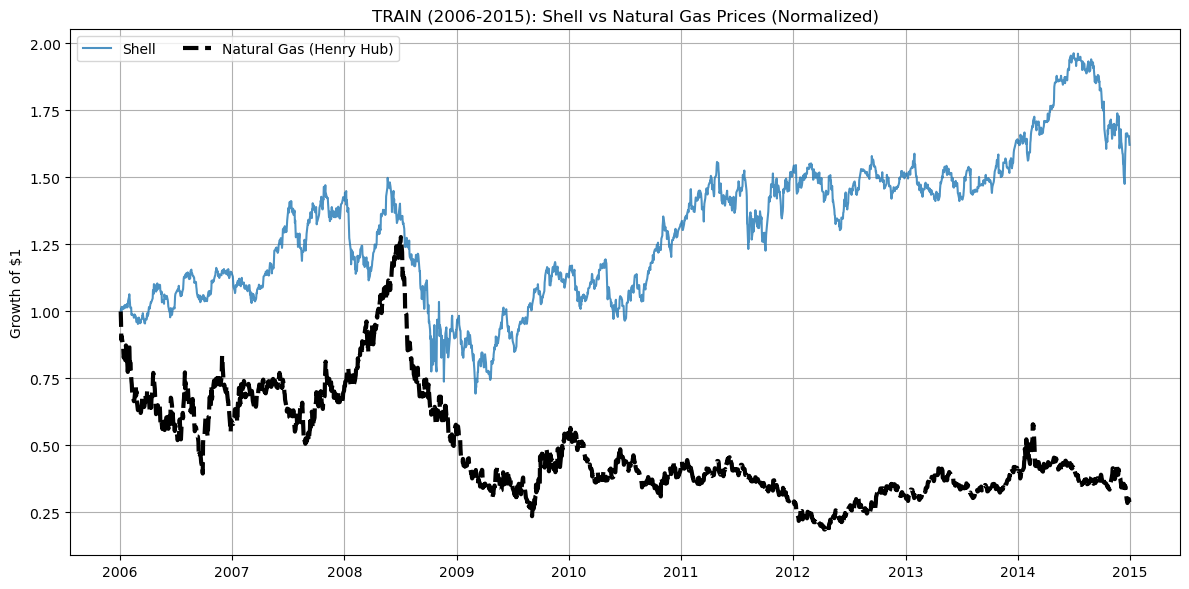

In [9]:
plt.figure(figsize=(12,6))

for name, ticker in lng_stocks.items():
    if ticker in normalized.columns:
        plt.plot(
            normalized.index,
            normalized[ticker],
            linewidth=1.5,
            alpha=0.8,
            label=name
        )

plt.plot(
    gas_norm.index,
    gas_norm,
    color="black",
    linewidth=3,
    linestyle="--",
    label="Natural Gas (Henry Hub)"
)

plt.title(f"{period_name}: Shell vs Natural Gas Prices (Normalized)")
plt.ylabel("Growth of $1")
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

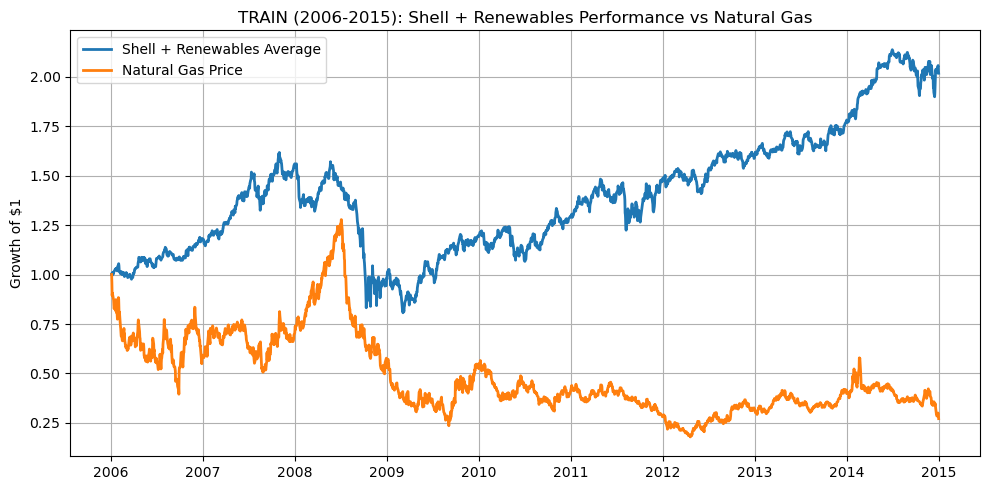

In [10]:
# Get Shell stocks
lng_avg = normalized[[t for t in lng_stocks.values() if t in normalized.columns]].mean(axis=1)

# Get renewable stocks
renew_avg = normalized[[t for t in renewable_stocks.values() if t in normalized.columns]].mean(axis=1)

# Combine Shell and renewables into a single average
combined_avg = pd.concat([lng_avg, renew_avg], axis=1).mean(axis=1)

plt.figure(figsize=(10,5))
plt.plot(combined_avg, label="Shell + Renewables Average", linewidth=2)
plt.plot(gas_norm, label="Natural Gas Price", linewidth=2)
plt.title(f"{period_name}: Shell + Renewables Performance vs Natural Gas")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
horizon = 63  # ~3 months (63 trading days)

lng_log = np.log(lng_avg)
gas_log = np.log(period_gas)

lng_3m = lng_log.shift(-horizon) - lng_log
gas_3m = gas_log.shift(-horizon) - gas_log

three_month = pd.concat([lng_3m, gas_3m], axis=1).dropna()
three_month.columns = ["LNG Equity 3M Return", "Gas 3M Return"]

corr_3m = three_month["LNG Equity 3M Return"].corr(three_month["Gas 3M Return"])

print(f"\n{period_name} 3-Month Rolling Correlation: {corr_3m:.4f}")


TRAIN (2006-2015) 3-Month Rolling Correlation: 0.2830


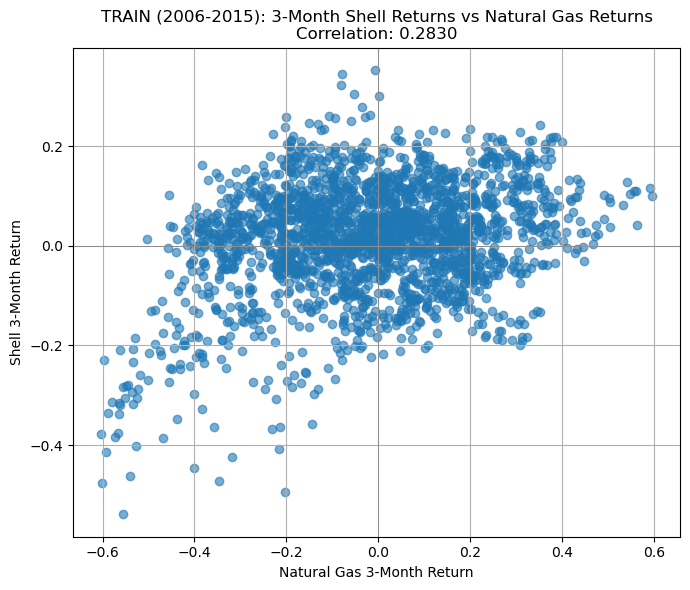

In [12]:
plt.figure(figsize=(7,6))
plt.scatter(
    three_month["Gas 3M Return"],
    three_month["LNG Equity 3M Return"],
    alpha=0.6
)

plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='-', linewidth=0.5)

plt.xlabel("Natural Gas 3-Month Return")
plt.ylabel("Shell 3-Month Return")
plt.title(f"{period_name}: 3-Month Shell Returns vs Natural Gas Returns\nCorrelation: {corr_3m:.4f}")

plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
lng_list = [t for t in lng_stocks.values() if t in period_data.columns]

prices_3m = period_data[lng_list].resample("QE").last()
gas_3m = period_gas.resample("QE").last()

lng_returns_3m = prices_3m.pct_change().dropna()
gas_returns_3m = gas_3m.pct_change().dropna()

if isinstance(gas_returns_3m, pd.DataFrame):
    gas_returns_3m = gas_returns_3m.squeeze()

lng_avg_3m = lng_returns_3m.mean(axis=1)

gas_prices_for_regime = gas_3m.shift(1).dropna()

if isinstance(gas_prices_for_regime, pd.DataFrame):
    gas_prices_for_regime = gas_prices_for_regime.squeeze()

# Align all series to common index
common_index = lng_avg_3m.index.intersection(gas_returns_3m.index).intersection(gas_prices_for_regime.index)
lng_avg_3m = lng_avg_3m.loc[common_index]
gas_returns_3m = gas_returns_3m.loc[common_index]
gas_prices_for_regime = gas_prices_for_regime.loc[common_index]

In [14]:
high_cut = gas_prices_for_regime.quantile(0.67)
low_cut = gas_prices_for_regime.quantile(0.33)

high_regime = gas_prices_for_regime >= high_cut
mid_regime = (gas_prices_for_regime > low_cut) & (gas_prices_for_regime < high_cut)
low_regime = gas_prices_for_regime <= low_cut

corr_high = lng_avg_3m[high_regime].corr(gas_returns_3m[high_regime])
corr_mid = lng_avg_3m[mid_regime].corr(gas_returns_3m[mid_regime])
corr_low = lng_avg_3m[low_regime].corr(gas_returns_3m[low_regime])

print(f"\n{period_name} Regime-Based Correlations:")
print(f"  High gas regime correlation: {corr_high:.4f}")
print(f"  Medium gas regime correlation: {corr_mid:.4f}")
print(f"  Low gas regime correlation: {corr_low:.4f}")


TRAIN (2006-2015) Regime-Based Correlations:
  High gas regime correlation: 0.3612
  Medium gas regime correlation: 0.4202
  Low gas regime correlation: -0.1794


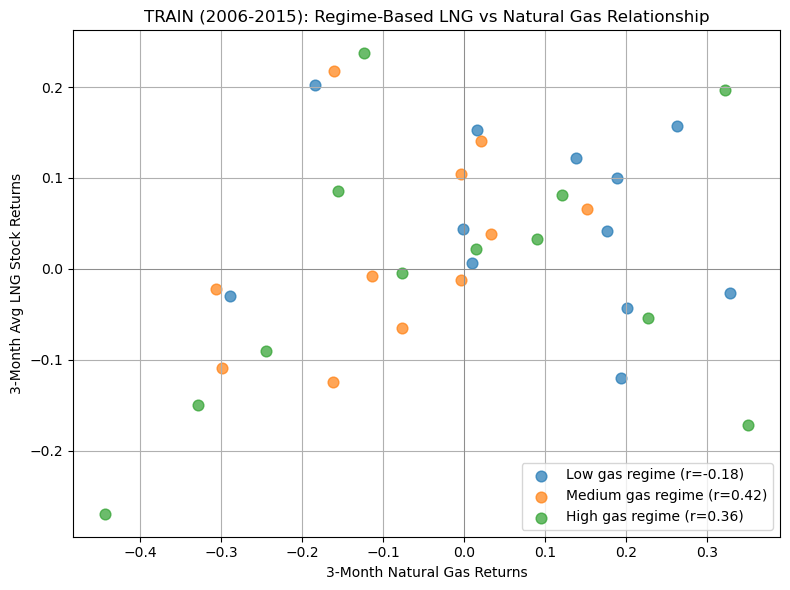

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(gas_returns_3m[low_regime], lng_avg_3m[low_regime], 
            alpha=0.7, s=60, label=f"Low gas regime (r={corr_low:.2f})")
plt.scatter(gas_returns_3m[mid_regime], lng_avg_3m[mid_regime], 
            alpha=0.7, s=60, label=f"Medium gas regime (r={corr_mid:.2f})")
plt.scatter(gas_returns_3m[high_regime], lng_avg_3m[high_regime], 
            alpha=0.7, s=60, label=f"High gas regime (r={corr_high:.2f})")

plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='-', linewidth=0.5)

plt.xlabel("3-Month Natural Gas Returns")
plt.ylabel("3-Month Avg LNG Stock Returns")
plt.title(f"{period_name}: Regime-Based LNG vs Natural Gas Relationship")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
train_results = {
    'correlation_3m': corr_3m,
    'corr_high': corr_high,
    'corr_mid': corr_mid,
    'corr_low': corr_low,
    'summary': summary,
    'lng_returns_3m': lng_avg_3m,
    'gas_returns_3m': gas_returns_3m,
    'gas_prices_for_regime': gas_prices_for_regime,
    'high_cut': high_cut,
    'low_cut': low_cut
}

print("\nTrain results stored!")


Train results stored!


In [17]:
# Change these variables to analyze test period
period_name = "TEST (2015-2025)"
start = test_start
end = test_end

print(f"\n{'='*60}")
print(f"ANALYZING {period_name} PERIOD: {start} to {end}")
print(f"{'='*60}\n")

# Filter data to period
data_mask = (data.index >= start) & (data.index < end)
gas_mask = (gas.index >= start) & (gas.index < end)

period_data = data[data_mask].copy()
period_gas = gas[gas_mask].copy()

# Align equity data: drop any dates where at least one stock is missing
period_data = period_data.dropna(how='any')

# Align gas data to equity data index
period_gas = period_gas.reindex(period_data.index).ffill()


ANALYZING TEST (2015-2025) PERIOD: 2015-01-01 to 2025-01-01



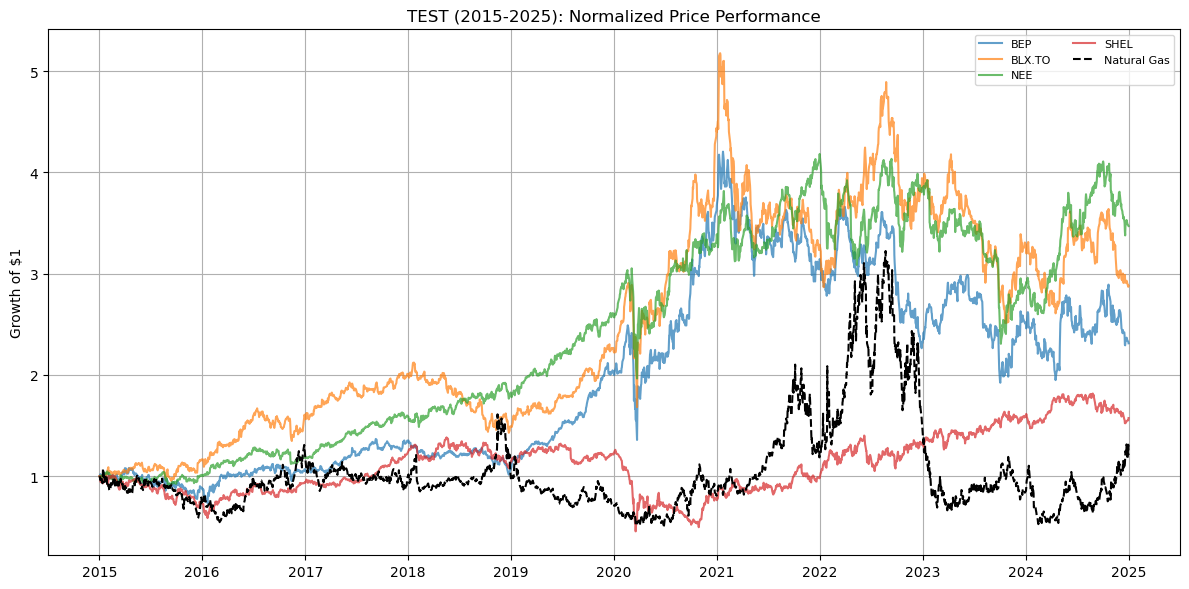

In [38]:
normalized = period_data / period_data.iloc[0]
gas_norm = period_gas / period_gas.iloc[0]

plt.figure(figsize=(12,6))
for col in normalized.columns:
    plt.plot(normalized.index, normalized[col], label=col, alpha=0.7)

plt.plot(gas_norm.index, gas_norm, color='black', linestyle='--', label='Natural Gas')

plt.title(f"{period_name}: Normalized Price Performance")
plt.ylabel("Growth of $1")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

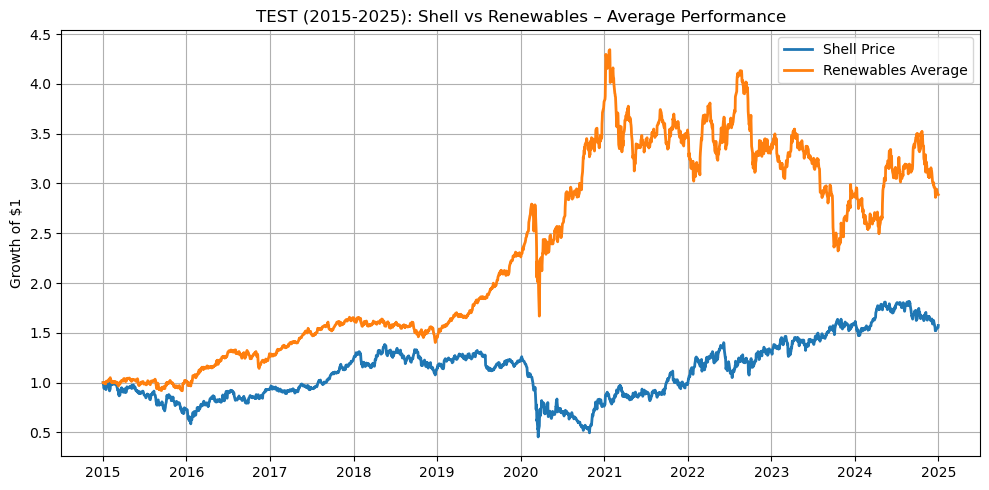

In [19]:
lng_prices = normalized[[t for t in lng_stocks.values() if t in normalized.columns]]
renew_prices = normalized[[t for t in renewable_stocks.values() if t in normalized.columns]]

lng_avg = lng_prices.mean(axis=1)
renew_avg = renew_prices.mean(axis=1)

plt.figure(figsize=(10,5))
plt.plot(lng_avg, label="Shell Price", linewidth=2)
plt.plot(renew_avg, label="Renewables Average", linewidth=2)

plt.title(f"{period_name}: Shell vs Renewables – Average Performance")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
returns = period_data.pct_change().dropna()

summary = pd.DataFrame({
    "Annual Return": returns.mean() * 252,
    "Annual Volatility": returns.std() * (252 ** 0.5)
})

print(f"\n{period_name} Risk-Return Summary:")
print(summary.sort_values("Annual Return", ascending=False))


TEST (2015-2025) Risk-Return Summary:
        Annual Return  Annual Volatility
Ticker                                  
NEE          0.157346           0.244621
BLX.TO       0.148336           0.283261
BEP          0.130298           0.298867
SHEL         0.095194           0.311302


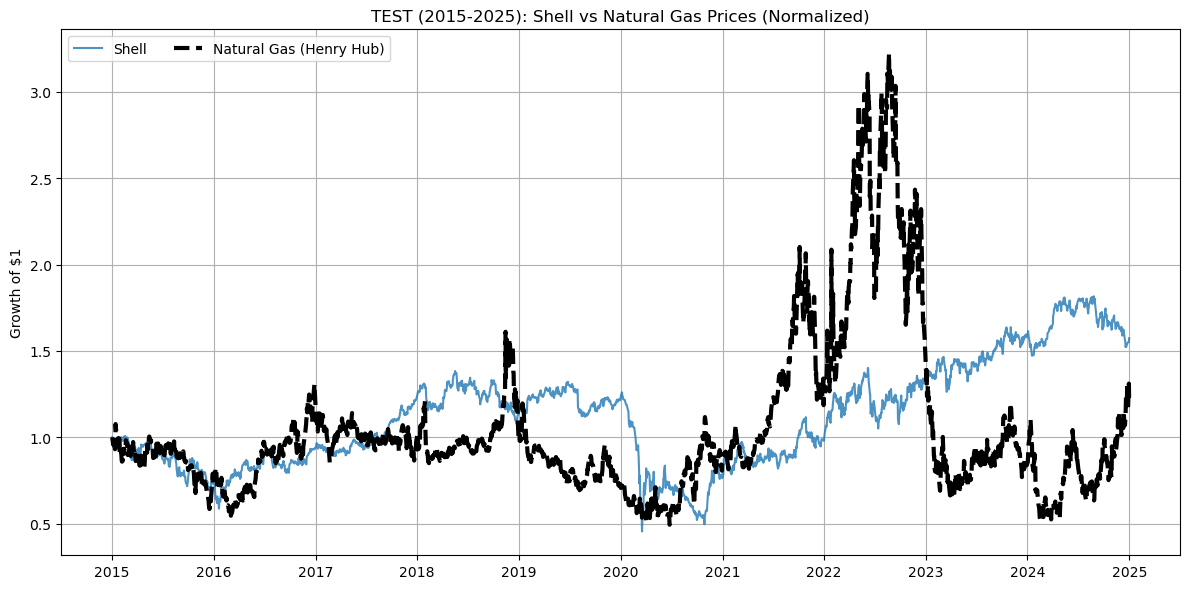

In [21]:
plt.figure(figsize=(12,6))

for name, ticker in lng_stocks.items():
    if ticker in normalized.columns:
        plt.plot(
            normalized.index,
            normalized[ticker],
            linewidth=1.5,
            alpha=0.8,
            label=name
        )

plt.plot(
    gas_norm.index,
    gas_norm,
    color="black",
    linewidth=3,
    linestyle="--",
    label="Natural Gas (Henry Hub)"
)

plt.title(f"{period_name}: Shell vs Natural Gas Prices (Normalized)")
plt.ylabel("Growth of $1")
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

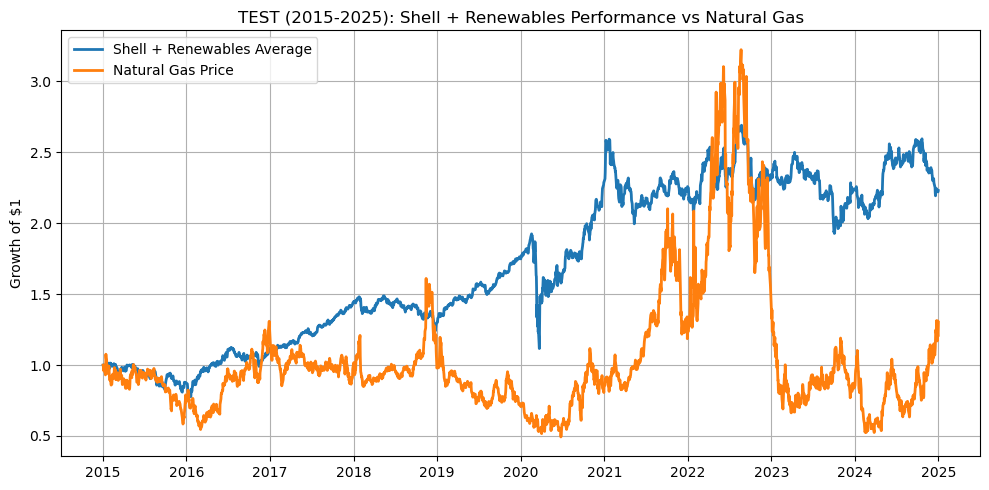

In [22]:
# Get Shell stocks
lng_avg = normalized[[t for t in lng_stocks.values() if t in normalized.columns]].mean(axis=1)

# Get renewable stocks
renew_avg = normalized[[t for t in renewable_stocks.values() if t in normalized.columns]].mean(axis=1)

# Combine Shell and renewables into a single average
combined_avg = pd.concat([lng_avg, renew_avg], axis=1).mean(axis=1)

plt.figure(figsize=(10,5))
plt.plot(combined_avg, label="Shell + Renewables Average", linewidth=2)
plt.plot(gas_norm, label="Natural Gas Price", linewidth=2)
plt.title(f"{period_name}: Shell + Renewables Performance vs Natural Gas")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
horizon = 63  # ~3 months (63 trading days)

lng_log = np.log(lng_avg)
gas_log = np.log(period_gas)

lng_3m = lng_log.shift(-horizon) - lng_log
gas_3m = gas_log.shift(-horizon) - gas_log

three_month = pd.concat([lng_3m, gas_3m], axis=1).dropna()
three_month.columns = ["LNG Equity 3M Return", "Gas 3M Return"]

corr_3m = three_month["LNG Equity 3M Return"].corr(three_month["Gas 3M Return"])

print(f"\n{period_name} 3-Month Rolling Correlation: {corr_3m:.4f}")


TEST (2015-2025) 3-Month Rolling Correlation: 0.0561


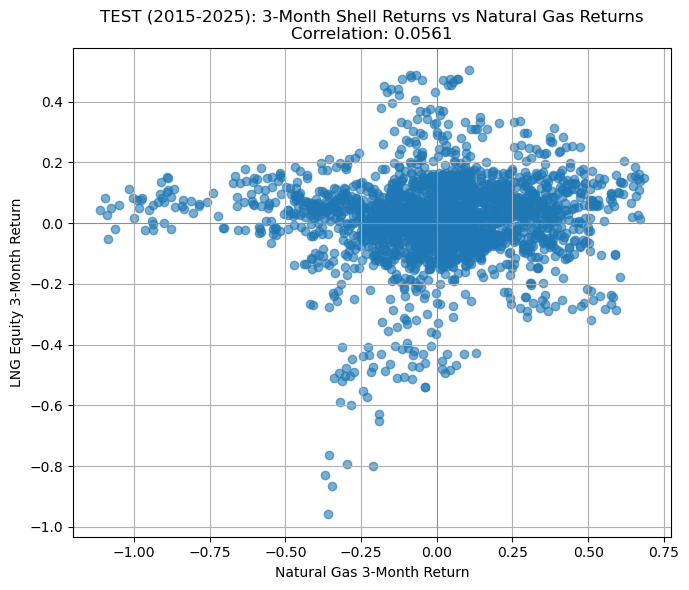

In [37]:
plt.figure(figsize=(7,6))
plt.scatter(
    three_month["Gas 3M Return"],
    three_month["LNG Equity 3M Return"],
    alpha=0.6
)

plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='-', linewidth=0.5)

plt.xlabel("Natural Gas 3-Month Return")
plt.ylabel("LNG Equity 3-Month Return")
plt.title(f"{period_name}: 3-Month Shell Returns vs Natural Gas Returns\nCorrelation: {corr_3m:.4f}")

plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
lng_list = [t for t in lng_stocks.values() if t in period_data.columns]

prices_3m = period_data[lng_list].resample("QE").last()
gas_3m = period_gas.resample("QE").last()

lng_returns_3m = prices_3m.pct_change().dropna()
gas_returns_3m = gas_3m.pct_change().dropna()

if isinstance(gas_returns_3m, pd.DataFrame):
    gas_returns_3m = gas_returns_3m.squeeze()

lng_avg_3m = lng_returns_3m.mean(axis=1)

gas_prices_for_regime = gas_3m.shift(1).dropna()

if isinstance(gas_prices_for_regime, pd.DataFrame):
    gas_prices_for_regime = gas_prices_for_regime.squeeze()

# Align all series to common index
common_index = lng_avg_3m.index.intersection(gas_returns_3m.index).intersection(gas_prices_for_regime.index)
lng_avg_3m = lng_avg_3m.loc[common_index]
gas_returns_3m = gas_returns_3m.loc[common_index]
gas_prices_for_regime = gas_prices_for_regime.loc[common_index]

In [26]:
high_cut = gas_prices_for_regime.quantile(0.67)
low_cut = gas_prices_for_regime.quantile(0.33)

high_regime = gas_prices_for_regime >= high_cut
mid_regime = (gas_prices_for_regime > low_cut) & (gas_prices_for_regime < high_cut)
low_regime = gas_prices_for_regime <= low_cut

corr_high = lng_avg_3m[high_regime].corr(gas_returns_3m[high_regime])
corr_mid = lng_avg_3m[mid_regime].corr(gas_returns_3m[mid_regime])
corr_low = lng_avg_3m[low_regime].corr(gas_returns_3m[low_regime])

print(f"\n{period_name} Regime-Based Correlations:")
print(f"  High gas regime correlation: {corr_high:.4f}")
print(f"  Medium gas regime correlation: {corr_mid:.4f}")
print(f"  Low gas regime correlation: {corr_low:.4f}")


TEST (2015-2025) Regime-Based Correlations:
  High gas regime correlation: 0.3658
  Medium gas regime correlation: 0.1501
  Low gas regime correlation: 0.1651


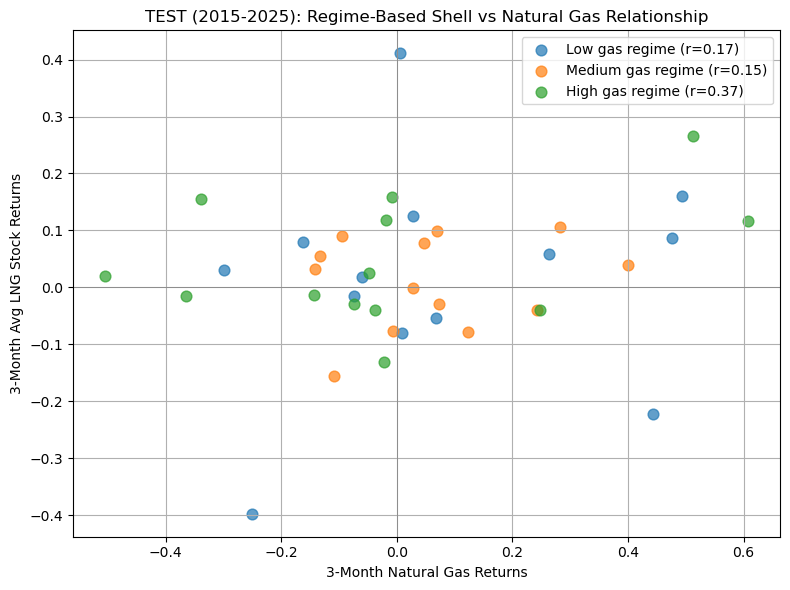

In [36]:
plt.figure(figsize=(8,6))
plt.scatter(gas_returns_3m[low_regime], lng_avg_3m[low_regime], 
            alpha=0.7, s=60, label=f"Low gas regime (r={corr_low:.2f})")
plt.scatter(gas_returns_3m[mid_regime], lng_avg_3m[mid_regime], 
            alpha=0.7, s=60, label=f"Medium gas regime (r={corr_mid:.2f})")
plt.scatter(gas_returns_3m[high_regime], lng_avg_3m[high_regime], 
            alpha=0.7, s=60, label=f"High gas regime (r={corr_high:.2f})")

plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='-', linewidth=0.5)

plt.xlabel("3-Month Natural Gas Returns")
plt.ylabel("3-Month Avg LNG Stock Returns")
plt.title(f"{period_name}: Regime-Based Shell vs Natural Gas Relationship")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
test_results = {
    'correlation_3m': corr_3m,
    'corr_high': corr_high,
    'corr_mid': corr_mid,
    'corr_low': corr_low,
    'summary': summary,
    'lng_returns_3m': lng_avg_3m,
    'gas_returns_3m': gas_returns_3m,
    'gas_prices_for_regime': gas_prices_for_regime,
    'high_cut': high_cut,
    'low_cut': low_cut
}

print("\nTest results stored!")


Test results stored!


In [29]:
print(f"\n{'='*60}")
print("COMPARISON SUMMARY")
print(f"{'='*60}")
print(f"\nOverall 3-Month Correlation:")
print(f"  Train (2005-2015): {train_results['correlation_3m']:.4f}")
print(f"  Test (2015-2025):  {test_results['correlation_3m']:.4f}")

print(f"\nRegime Correlations:")
print(f"  High Gas - Train: {train_results['corr_high']:.4f} | Test: {test_results['corr_high']:.4f}")
print(f"  Mid Gas  - Train: {train_results['corr_mid']:.4f} | Test: {test_results['corr_mid']:.4f}")
print(f"  Low Gas  - Train: {train_results['corr_low']:.4f} | Test: {test_results['corr_low']:.4f}")



COMPARISON SUMMARY

Overall 3-Month Correlation:
  Train (2005-2015): 0.2830
  Test (2015-2025):  0.0561

Regime Correlations:
  High Gas - Train: 0.3612 | Test: 0.3658
  Mid Gas  - Train: 0.4202 | Test: 0.1501
  Low Gas  - Train: -0.1794 | Test: 0.1651


In [30]:
def prepare_regression_data(results):
    """Prepare regression data with interaction terms"""
    lng_ret = results['lng_returns_3m']
    gas_ret = results['gas_returns_3m']
    gas_prices = results['gas_prices_for_regime']
    high_cut = results['high_cut']
    low_cut = results['low_cut']
    
    # Create regime dummies
    D_medium = ((gas_prices > low_cut) & (gas_prices < high_cut)).astype(int)
    D_high = (gas_prices >= high_cut).astype(int)
    
    # Create interaction terms
    gas_medium_interact = gas_ret * D_medium
    gas_high_interact = gas_ret * D_high
    
    # Combine into feature matrix
    X = pd.DataFrame({
        'R_gas': gas_ret,
        'R_gas_medium': gas_medium_interact,
        'R_gas_high': gas_high_interact
    })
    
    y = lng_ret
    
    return X, y, D_medium, D_high

In [31]:
print(f"\n{'='*60}")
print("LINEAR REGRESSION ANALYSIS")
print(f"{'='*60}")

# Prepare training data
X_train, y_train, D_medium_train, D_high_train = prepare_regression_data(train_results)

# Fit the model on training data
model = LinearRegression()
model.fit(X_train, y_train)

# Get predictions on training data
y_train_pred = model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Print training results
print("\nTRAINING PERIOD (2005-2015) RESULTS:")
print(f"Model: R_LNG = α + β*R_gas + γ_medium*R_gas*D_medium + γ_high*R_gas*D_high + ε")
print(f"\nCoefficients:")
print(f"  α (intercept):           {model.intercept_:.6f}")
print(f"  β (R_gas):               {model.coef_[0]:.6f}")
print(f"  γ_medium (R_gas*D_med):  {model.coef_[1]:.6f}")
print(f"  γ_high (R_gas*D_high):   {model.coef_[2]:.6f}")
print(f"\nTraining R²:   {train_r2:.4f}")
print(f"Training RMSE: {train_rmse:.6f}")


LINEAR REGRESSION ANALYSIS

TRAINING PERIOD (2005-2015) RESULTS:
Model: R_LNG = α + β*R_gas + γ_medium*R_gas*D_medium + γ_high*R_gas*D_high + ε

Coefficients:
  α (intercept):           0.030778
  β (R_gas):               -0.031749
  γ_medium (R_gas*D_med):  0.292180
  γ_high (R_gas*D_high):   0.256732

Training R²:   0.1082
Training RMSE: 0.110837


In [32]:
# Prepare test data
X_test, y_test, D_medium_test, D_high_test = prepare_regression_data(test_results)

# Get predictions on test data
y_test_pred = model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Print test results
print("\nTEST PERIOD (2015-2025) RESULTS:")
print(f"Test R²:   {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:.6f}")


TEST PERIOD (2015-2025) RESULTS:
Test R²:   -0.0375
Test RMSE: 0.133940


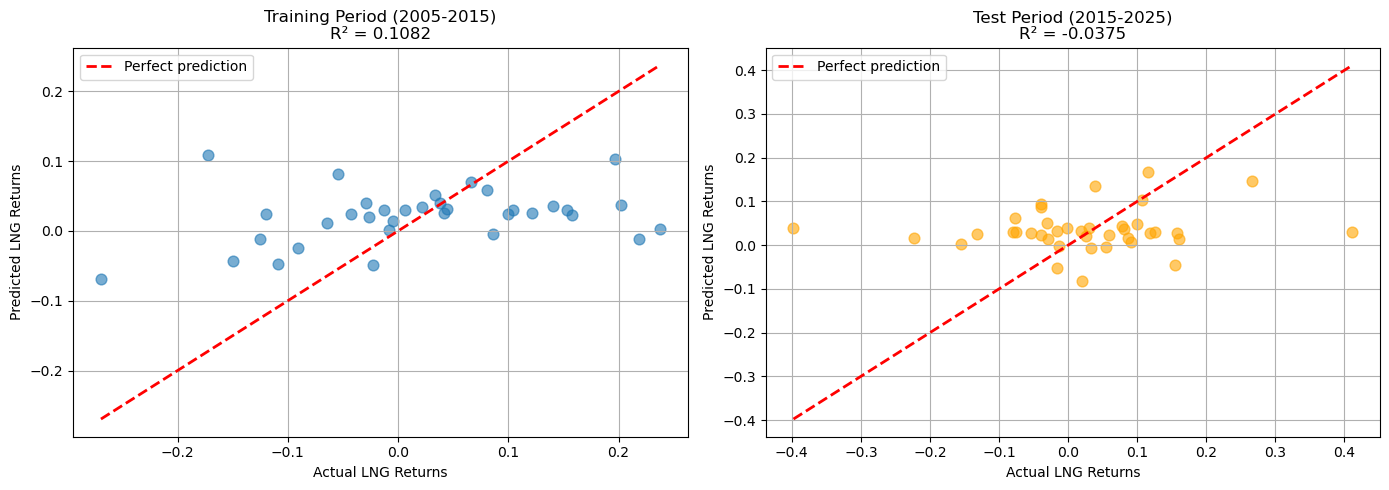

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training plot
axes[0].scatter(y_train, y_train_pred, alpha=0.6, s=60)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Actual LNG Returns')
axes[0].set_ylabel('Predicted LNG Returns')
axes[0].set_title(f'Training Period (2005-2015)\nR² = {train_r2:.4f}')
axes[0].legend()
axes[0].grid(True)

# Test plot
axes[1].scatter(y_test, y_test_pred, alpha=0.6, s=60, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect prediction')
axes[1].set_xlabel('Actual LNG Returns')
axes[1].set_ylabel('Predicted LNG Returns')
axes[1].set_title(f'Test Period (2015-2025)\nR² = {test_r2:.4f}')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

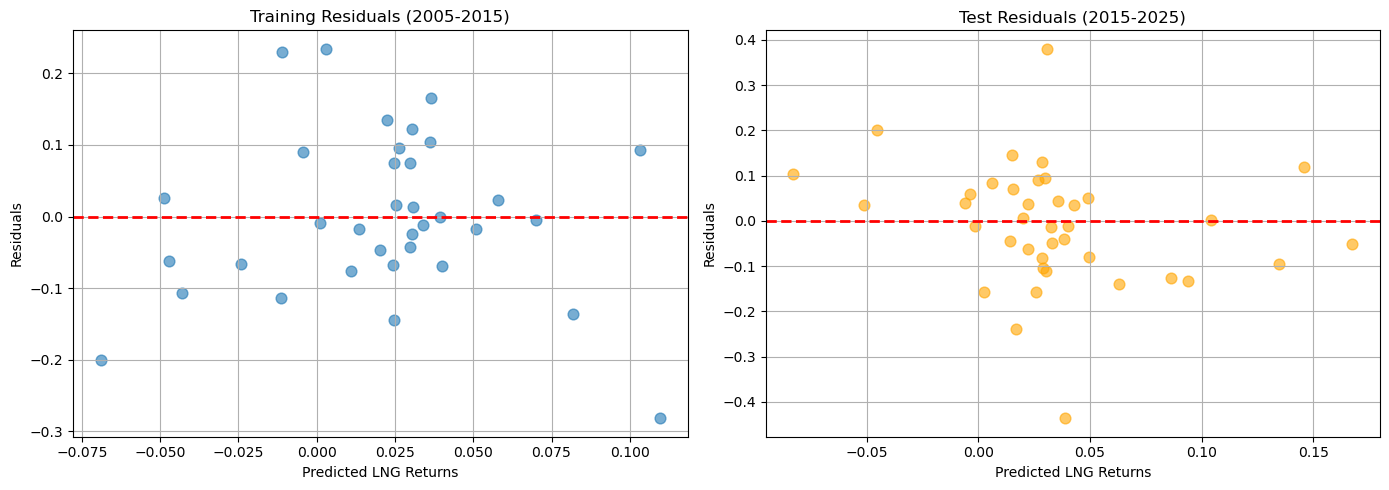

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

# Training residuals
axes[0].scatter(y_train_pred, residuals_train, alpha=0.6, s=60)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted LNG Returns')
axes[0].set_ylabel('Residuals')
axes[0].set_title(f'Training Residuals (2005-2015)')
axes[0].grid(True)

# Test residuals
axes[1].scatter(y_test_pred, residuals_test, alpha=0.6, s=60, color='orange')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted LNG Returns')
axes[1].set_ylabel('Residuals')
axes[1].set_title(f'Test Residuals (2015-2025)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [35]:
# Coefficient interpretation
print("\n" + "="*60)
print("COEFFICIENT INTERPRETATION")
print("="*60)
print("\nThe model estimates:")
print(f"  • Base effect of gas returns (low regime): {model.coef_[0]:.4f}")
print(f"  • Additional effect in medium regime: {model.coef_[1]:.4f}")
print(f"  • Additional effect in high regime: {model.coef_[2]:.4f}")
print(f"\nTotal effects by regime:")
print(f"  • Low gas regime:    β = {model.coef_[0]:.4f}")
print(f"  • Medium gas regime: β = {model.coef_[0] + model.coef_[1]:.4f}")
print(f"  • High gas regime:   β = {model.coef_[0] + model.coef_[2]:.4f}")


COEFFICIENT INTERPRETATION

The model estimates:
  • Base effect of gas returns (low regime): -0.0317
  • Additional effect in medium regime: 0.2922
  • Additional effect in high regime: 0.2567

Total effects by regime:
  • Low gas regime:    β = -0.0317
  • Medium gas regime: β = 0.2604
  • High gas regime:   β = 0.2250


In [39]:
# Evaluate model performance in HIGH REGIME only

# Training period - high regime
high_regime_train = (train_results['gas_prices_for_regime'] >= train_results['high_cut'])
X_train_high = X_train[high_regime_train]
y_train_high = y_train[high_regime_train]
y_train_high_pred = model.predict(X_train_high)

train_high_r2 = r2_score(y_train_high, y_train_high_pred)
train_high_rmse = np.sqrt(mean_squared_error(y_train_high, y_train_high_pred))

# Test period - high regime
high_regime_test = (test_results['gas_prices_for_regime'] >= test_results['high_cut'])
X_test_high = X_test[high_regime_test]
y_test_high = y_test[high_regime_test]
y_test_high_pred = model.predict(X_test_high)

test_high_r2 = r2_score(y_test_high, y_test_high_pred)
test_high_rmse = np.sqrt(mean_squared_error(y_test_high, y_test_high_pred))

# Print results
print(f"\n{'='*60}")
print("HIGH REGIME PERFORMANCE")
print(f"{'='*60}")
print(f"\nTraining Period (2005-2015) - High Regime:")
print(f"  N observations: {len(y_train_high)}")
print(f"  R²:   {train_high_r2:.4f}")
print(f"  RMSE: {train_high_rmse:.6f}")

print(f"\nTest Period (2015-2025) - High Regime:")
print(f"  N observations: {len(y_test_high)}")
print(f"  R²:   {test_high_r2:.4f}")
print(f"  RMSE: {test_high_rmse:.6f}")


HIGH REGIME PERFORMANCE

Training Period (2005-2015) - High Regime:
  N observations: 12
  R²:   0.0759
  RMSE: 0.137500

Test Period (2015-2025) - High Regime:
  N observations: 13
  R²:   0.0195
  RMSE: 0.103854


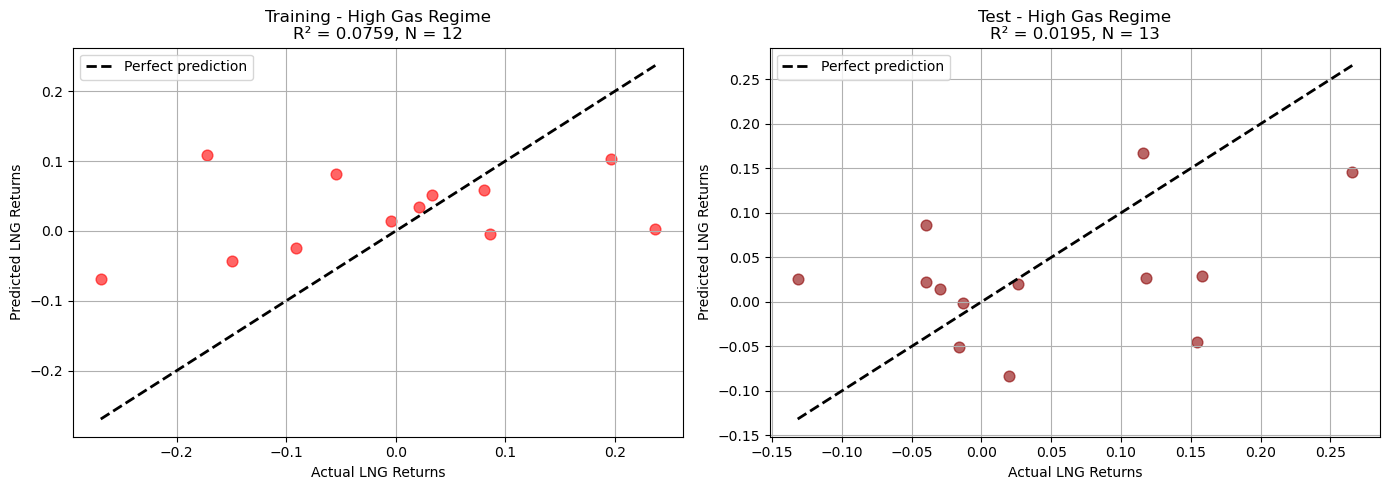

In [41]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training - high regime
axes[0].scatter(y_train_high, y_train_high_pred, alpha=0.6, s=60, color='red')
axes[0].plot([y_train_high.min(), y_train_high.max()], 
             [y_train_high.min(), y_train_high.max()], 
             'k--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Actual LNG Returns')
axes[0].set_ylabel('Predicted LNG Returns')
axes[0].set_title(f'Training - High Gas Regime\nR² = {train_high_r2:.4f}, N = {len(y_train_high)}')
axes[0].legend()
axes[0].grid(True)

# Test - high regime
axes[1].scatter(y_test_high, y_test_high_pred, alpha=0.6, s=60, color='darkred')
axes[1].plot([y_test_high.min(), y_test_high.max()], 
             [y_test_high.min(), y_test_high.max()], 
             'k--', lw=2, label='Perfect prediction')
axes[1].set_xlabel('Actual LNG Returns')
axes[1].set_ylabel('Predicted LNG Returns')
axes[1].set_title(f'Test - High Gas Regime\nR² = {test_high_r2:.4f}, N = {len(y_test_high)}')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()